In [7]:
import fastai

In [8]:
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

In [ ]:
(path/'train').ls()

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

In [12]:
from PIL import Image

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [13]:
import numpy as np

In [14]:
from torch import tensor
import pandas as pd

In [15]:
np.array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [16]:

im3_t = tensor(np.array(im3))
df=pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [17]:
seven_tensors = [tensor(np.array(Image.open(o))) for o in sevens]
three_tensors = [tensor(np.array(Image.open(o))) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

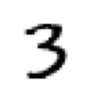

In [18]:
from fastai.vision.all import show_image
show_image(three_tensors[1],cmap="Greys");

In [19]:
three_tensors[1].shape

torch.Size([28, 28])

In [20]:
import torch
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255



images/pixel/pixel

In [21]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

the lenght of a tensor shape is its rank

In [22]:
len(stacked_threes.shape)

3

In [23]:
stacked_threes.ndim

3

<Axes: >

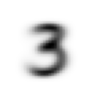

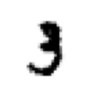

In [24]:
mean3= stacked_threes.mean(0)
show_image(mean3,cmap="Greys");
show_image(stacked_threes[0],cmap="Greys")

<Axes: >

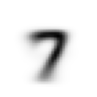

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7, cmap='Greys')

<Axes: >

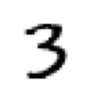

In [26]:
a_3 = stacked_threes[1]
show_image(a_3, cmap='Greys')

In [27]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [28]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [29]:
import torch.nn.functional as F
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [30]:
valid_3_tens = torch.stack([tensor(np.array(Image.open(o))) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

In [31]:
valid_7_tens = torch.stack([tensor(np.array(Image.open(o))) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [32]:
valid_3_tens.shape , valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [33]:
def mnist_distance(a,b) : return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [34]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [35]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [36]:
is_3(valid_3_tens), is_3(a_3).float()

(tensor([True, True, True,  ..., True, True, True]), tensor(1.))

In [37]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

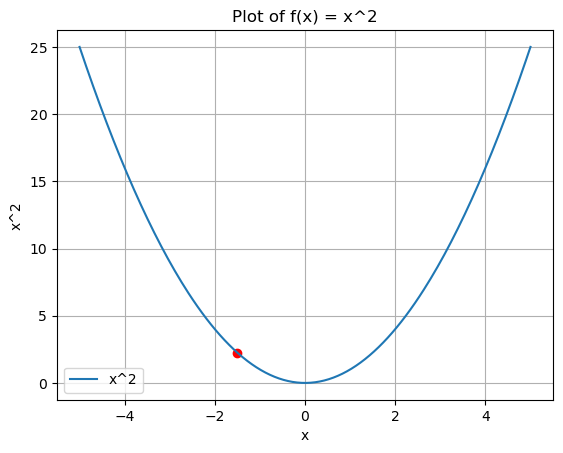

In [38]:

def f(x): return x**2

import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**2

# Create x values
x = np.linspace(-5, 5, 200)  # from -5 to 5, 200 points
y = f(x)

# Plot
plt.plot(x, y, label="x^2")
plt.xlabel("x")
plt.ylabel("x^2")
plt.title("Plot of f(x) = x^2")
plt.legend()
plt.grid(True)
plt.scatter(-1.5, f(-1.5), color='red')
plt.show()

In [39]:
xt = tensor(3.).requires_grad_()

In [40]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [41]:
yt.backward()

In [42]:
xt.grad

tensor(6.)

In [43]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [44]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape, train_x.shape

(torch.Size([12396, 1]), torch.Size([12396, 784]))

In [45]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [46]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [47]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))

In [48]:
bias = init_params(1)

In [49]:
(train_x[0]*weights.T).sum()+bias

tensor([-20.4974], grad_fn=<AddBackward0>)

In [50]:
train_x.shape, weights.shape

(torch.Size([12396, 784]), torch.Size([784, 1]))

In [51]:
def linear1(xb): return xb@weights +bias
preds = linear1(train_x)
preds

tensor([[-20.4974],
        [-26.6813],
        [-21.0971],
        ...,
        [-14.3622],
        [-22.0075],
        [-16.9297]], grad_fn=<AddBackward0>)

In [52]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [53]:
corrects.float().mean().item()

0.513875424861908

In [54]:
weights.data[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.513875424861908

This measures the error for each prediction:

If label = 1, we want prediction close to 1 → error = 1 - prediction.

Example: target=1, prediction=0.9 → error=0.1 (good)

Example: target=1, prediction=0.2 → error=0.8 (bad)

If label = 0, we want prediction close to 0 → error = prediction.

Example: target=0, prediction=0.1 → error=0.1 (good)

Example: target=0, prediction=0.7 → error=0.7 (bad)

In [55]:
def mnist_loss(predictions, targets):
       return torch.where(targets==1, 1-predictions, predictions).mean()

In [56]:
from torch.utils.data import DataLoader

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 5, 11,  0, 14,  9]),
 tensor([ 4,  1,  2, 13,  3]),
 tensor([10,  7,  6, 12,  8])]

In [57]:
from fastcore.foundation import L
import string

ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [58]:

dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[[tensor([14, 20, 15, 23,  5, 11]), ('o', 'u', 'p', 'x', 'f', 'l')],
 [tensor([21, 19,  0, 24, 12,  2]), ('v', 't', 'a', 'y', 'm', 'c')],
 [tensor([10, 13, 16,  6,  7,  9]), ('k', 'n', 'q', 'g', 'h', 'j')],
 [tensor([18, 17,  1, 25,  3,  8]), ('s', 'r', 'b', 'z', 'd', 'i')],
 [tensor([ 4, 22]), ('e', 'w')]]

In [59]:
weights = init_params((28*28,1))
bias = init_params(1)

In [105]:
from fastcore.utils import first

dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [106]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [107]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [114]:
preds = linear1(batch)
preds

tensor([[39.1135],
        [62.6345],
        [63.9271],
        [75.6520]], grad_fn=<AddBackward0>)

In [115]:
loss = mnist_loss(preds, train_x[:4])
loss

tensor(60.2038, grad_fn=<MeanBackward0>)

In [116]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(0.1508), tensor([0.9981]))

In [117]:
weights[0], weights.grad.max()

(tensor([0.2893], grad_fn=<SelectBackward0>), tensor(0.9952))

In [118]:
def calc_grad(xb, yb, model):
       preds = model(xb)
       loss = mnist_loss(preds, yb)
       loss.backward()

In [119]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0003), tensor([-0.0019]))

In [120]:
weights.grad.zero_()
bias.grad.zero_();

In [121]:
def train_epoch(model, lr, prams):
       for xb, yb in dl:
              calc_grad(xb, yb, model)
              for p in prams:
                     p.data -= p.grad*lr
                     p.grad.zero_()


In [122]:
def batch_accuracy(xb, yb):
       preds= xb.sigmoid()
       correct = (preds>0.5) == yb
       return correct.float().mean()

In [123]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [124]:
def validate_epoch(model):
       accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
       return round(torch.stack(accs).mean().item(),4)

In [125]:
validate_epoch(linear1)

0.9376

In [126]:
lr =0.1
prams = weights, bias
train_epoch(linear1, lr, prams)
validate_epoch(linear1)


0.9513

In [127]:
for i in range(20):
       train_epoch(linear1, lr, prams)
       print(validate_epoch(linear1), end=' ')

0.9542 0.9552 0.9543 0.9547 0.9547 0.9547 0.9547 0.9533 0.9533 0.9538 0.9538 0.9538 0.9543 0.9543 0.9543 0.9543 0.9538 0.9538 0.9538 0.9538 

In [128]:
import torch.nn as nn
linear_model = nn.Linear(28*28,1)

In [129]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [130]:
class BasicOptim:
       def __init__(self, params, lr):
              self.params,self.lr = list(params),lr
       def step(self, *args, **kwargs):
             for p in self.params: p.data -= p.grad.data * self.lr 
       def zero_grad(self, *args, **kwargs):
              for p in self.params: p.grad = None
       

In [131]:
opt = BasicOptim(linear_model.parameters(), lr)

In [132]:
def train_epoch(model):
       for xb,yb in dl:
              calc_grad(xb, yb, model)
              opt.step()
              opt.zero_grad()

In [133]:
def train_model(model, epochs):
       for i in range(epochs):
              train_epoch(model)
              print(validate_epoch(model), end=' ')

In [134]:
train_model(linear_model, 20)

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

In [135]:
from torch.optim import SGD

opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

In [136]:
from fastai.data.core import DataLoaders
from fastai.vision.all import *

dls = DataLoaders(dl, valid_dl)

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [137]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,-7.916694,-33.127659,0.952895,00:00
1,-30.554014,-66.759346,0.952895,00:00
2,-56.692810,-100.391029,0.953386,00:00
3,-85.118134,-134.022705,0.953386,00:00
4,-114.861137,-167.654404,0.953386,00:00
5,-145.294479,-201.286102,0.953386,00:00
6,-176.064941,-234.917770,0.953386,00:00
7,-206.991806,-268.549469,0.953386,00:00
8,-237.988602,-302.181183,0.953386,00:00
9,-269.015778,-335.812805,0.953386,00:00


In [138]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)


In [139]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,-7.917345,-33.142685,0.953876,00:00
1,-30.554667,-66.774368,0.953386,00:00
2,-56.693455,-100.406067,0.953386,00:00
3,-85.118797,-134.037750,0.953386,00:00
4,-114.861839,-167.669434,0.953386,00:00
5,-145.295151,-201.301117,0.953386,00:00
6,-176.065598,-234.932831,0.953386,00:00
7,-206.992477,-268.564484,0.953386,00:00
8,-237.989334,-302.196167,0.953386,00:00
9,-269.016510,-335.827850,0.953386,00:00


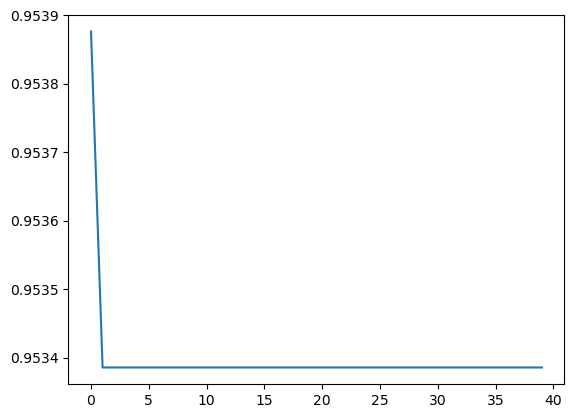

In [140]:
plt.plot(L(learn.recorder.values).itemgot(2))